### Loading Files

In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bengaliai-cv19/test_image_data_0.parquet
/kaggle/input/bengaliai-cv19/sample_submission.csv
/kaggle/input/bengaliai-cv19/test_image_data_3.parquet
/kaggle/input/bengaliai-cv19/train_image_data_0.parquet
/kaggle/input/bengaliai-cv19/test_image_data_1.parquet
/kaggle/input/bengaliai-cv19/train_image_data_2.parquet
/kaggle/input/bengaliai-cv19/train_image_data_3.parquet
/kaggle/input/bengaliai-cv19/test_image_data_2.parquet
/kaggle/input/bengaliai-cv19/train_image_data_1.parquet
/kaggle/input/bengaliai-cv19/class_map.csv
/kaggle/input/bengaliai-cv19/test.csv
/kaggle/input/bengaliai-cv19/train.csv


In [2]:
import pandas as pd
class_map_df = pd.read_csv("../input/bengaliai-cv19/class_map.csv")
sample_submission = pd.read_csv("../input/bengaliai-cv19/sample_submission.csv")
test_df = pd.read_csv("../input/bengaliai-cv19/test.csv")
train_df = pd.read_csv("../input/bengaliai-cv19/train.csv")

### Exploratory Data Analysis:

In [3]:
train_df.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [4]:
test_df.head()

,row_id,image_id,component
0,Test_0_consonant_diacritic,Test_0,consonant_diacritic
1,Test_0_grapheme_root,Test_0,grapheme_root
2,Test_0_vowel_diacritic,Test_0,vowel_diacritic
3,Test_1_consonant_diacritic,Test_1,consonant_diacritic
4,Test_1_grapheme_root,Test_1,grapheme_root


In [5]:
class_map_df.head()

,component_type,label,component
0,grapheme_root,0,ং
1,grapheme_root,1,ঃ
2,grapheme_root,2,অ
3,grapheme_root,3,আ
4,grapheme_root,4,ই


In [6]:
print('Rows, Columns: training data: {}, test data {}, class map: {}'.format(train_df.shape, test_df.shape, class_map_df.shape))

Rows, Columns: training data: (200840, 5), test data (36, 3), class map: (186, 3)


In [7]:
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

train_images = ['../input/bengaliai-cv19/train_image_data_0.parquet',
         '../input/bengaliai-cv19/train_image_data_1.parquet',
         '../input/bengaliai-cv19/train_image_data_2.parquet',
         '../input/bengaliai-cv19/train_image_data_3.parquet']

test_images = ['../input/bengaliai-cv19/test_image_data_0.parquet',
         '../input/bengaliai-cv19/test_image_data_1.parquet',
         '../input/bengaliai-cv19/test_image_data_2.parquet',
         '../input/bengaliai-cv19/test_image_data_3.parquet']

train_0_data = pd.read_parquet(train_images[0])

In [8]:
train_0_data

,image_id,0,1,2,3,4,5,6,7,8,...,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,Train_0,254,253,252,253,251,252,253,251,251,...,253,253,253,253,253,253,253,253,253,251
1,Train_1,251,244,238,245,248,246,246,247,251,...,255,255,255,255,255,255,255,255,255,254
2,Train_2,251,250,249,250,249,245,247,252,252,...,254,253,252,252,253,253,253,253,251,249
3,Train_3,247,247,249,253,253,252,251,251,250,...,254,254,254,254,254,253,253,252,251,252
4,Train_4,249,248,246,246,248,244,242,242,229,...,255,255,255,255,255,255,255,255,255,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50205,Train_50205,247,250,250,250,252,250,250,250,251,...,246,248,252,252,249,248,250,247,243,243
50206,Train_50206,250,251,250,244,245,243,246,248,246,...,255,255,255,255,255,255,255,255,255,253
50207,Train_50207,246,245,246,246,245,245,247,247,245,...,247,246,248,246,245,248,249,246,243,245
50208,Train_50208,246,242,240,244,247,242,239,241,245,...,247,247,247,247,247,246,246,248,248,247


In [9]:
def display_images(images):
    fig, axs = plt.subplots(3, 5, figsize=(25, 10))
    axs.flatten()

    for i in range(len(images)):
        row = int(i / 5)
        column = int(i % 5)
        axs[row,column].imshow(images[i], cmap="Greys")

    plt.show()

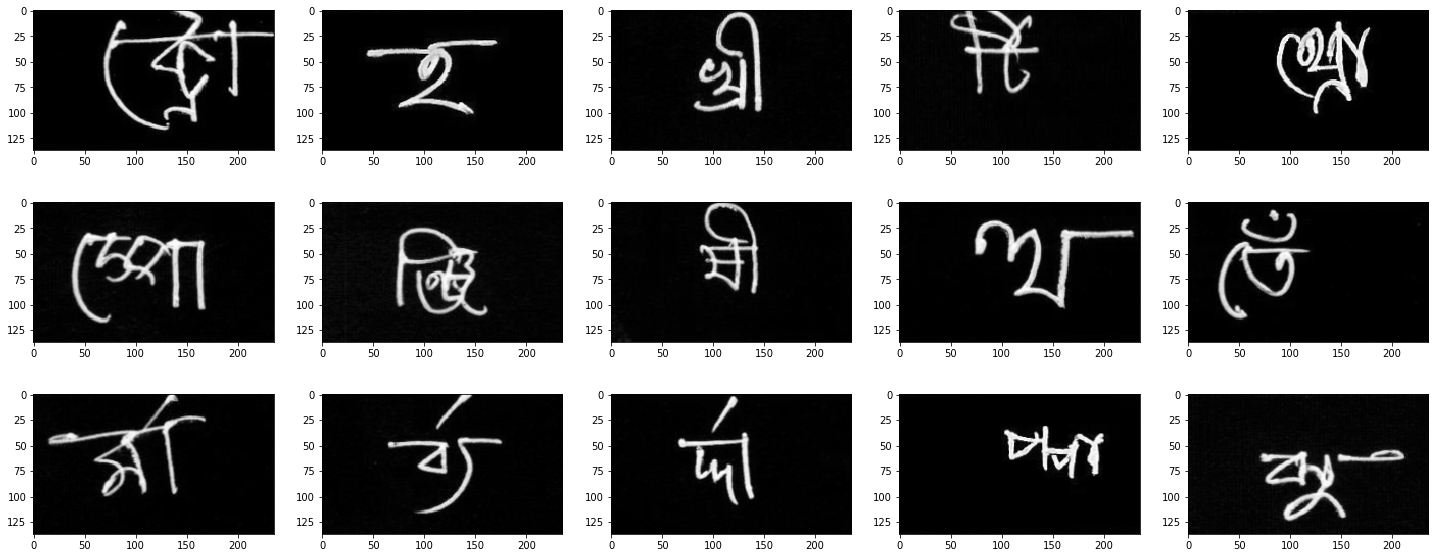

In [10]:
NUM_IMAGES = 15
images = []

for i in range(NUM_IMAGES):
    img = train_0_data.iloc[i, 1:].values.reshape(137, 236).astype(np.uint8)
    images.append(img)

display_images(images)

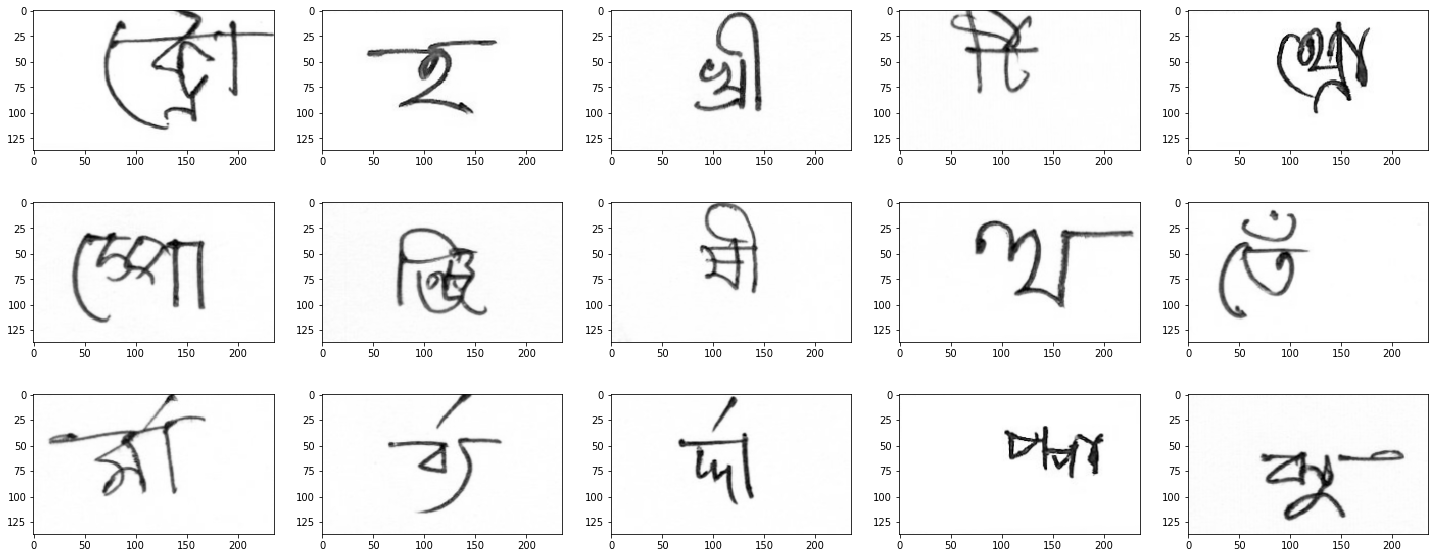

In [11]:
#invert images
inverted_images = []
for img in images:
    img = 255-img
    inverted_images.append(img)
    
display_images(inverted_images)

### Data Preprocessing:

In [12]:
import cv2

def crop_resize_preprocess(img):
    #bounding_img = img[5:-5, 5:-5] > 50
    bounding_img = img
    x_axis = np.any(bounding_img, axis=0)
    y_axis = np.any(bounding_img, axis=1)
    xmin, xmax = np.where(x_axis)[0][[0,-1]]
    ymin, ymax = np.where(y_axis)[0][[0,-1]]
    
    xmin -= 15 if (xmin>15) else 0
    xmax += 15 if (xmax<236-15) else 236
    ymin -= 15 if (ymin>15) else 0
    ymax += 15 if (ymax<137-55) else 137
    img = img[ymin:ymax, xmin:xmax]
    
    img = np.pad(img, [5, 5], mode='constant')
    return cv2.resize(img, (128, 128))

Original Images:


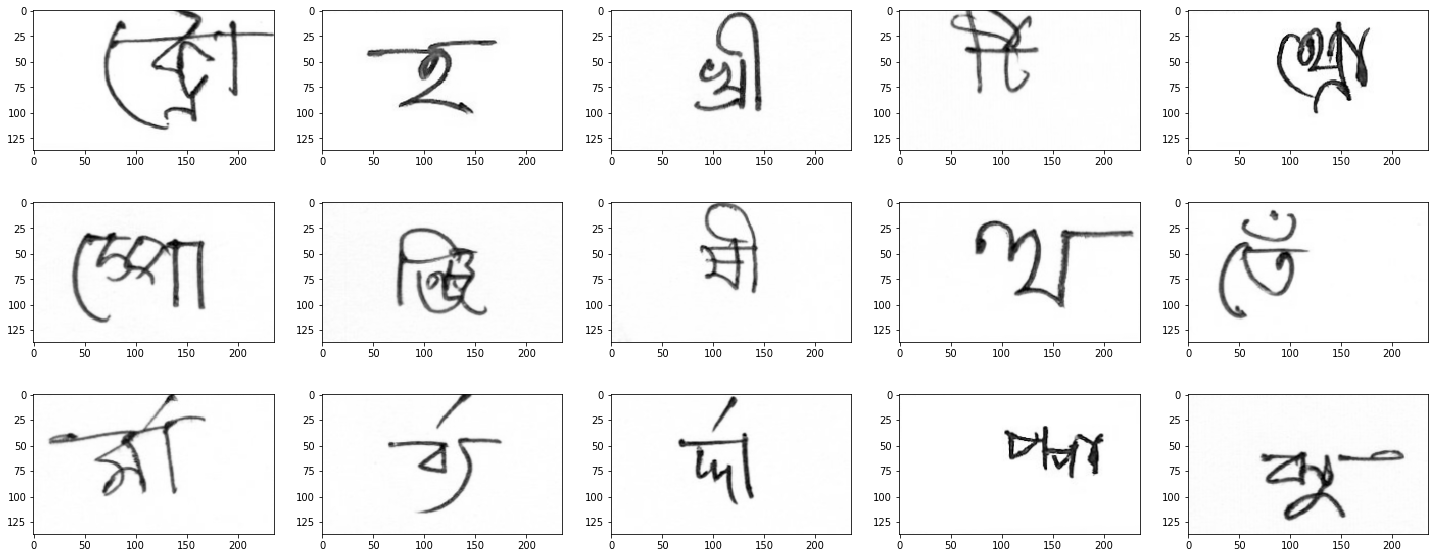

Preprocessed Images:


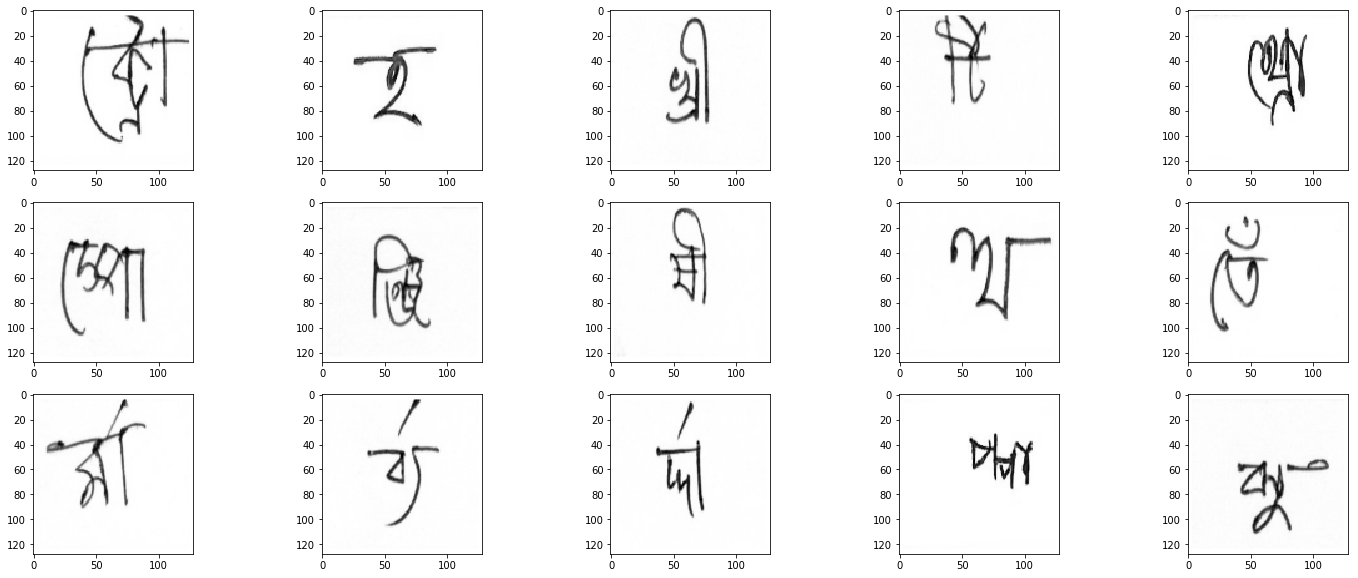

In [13]:
print("Original Images:")
display_images(inverted_images)

preprocessed_images = []
for img in inverted_images:
    img = crop_resize_preprocess(img)
    preprocessed_images.append(img)
    
print("Preprocessed Images:")
display_images(preprocessed_images)

### Keras Model

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Concatenate, GlobalAveragePooling2D, AveragePooling2D, MaxPool2D,Dropout,BatchNormalization, Input
from tensorflow.keras.models import Model

def initialise_model():
    input_shape = Input(shape=(128, 128, 1))

    #Convolution 7x7:
    conv_7x7 = Conv2D(filters=64, kernel_size=(7,7), strides=(2,2), activation="relu", padding='same', 
        kernel_initializer= tf.keras.initializers.glorot_uniform(), bias_initializer= tf.keras.initializers.Constant(value=0.2))(input_shape)

    #MaxPool:
    max_pool = MaxPool2D(pool_size=(3, 3), strides=(2,2), padding='same')(conv_7x7)

    #Convolution 1x1:
    conv_7x7x1 = Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation="relu", padding='same')(max_pool)

    #Convolution 3x3:
    conv_3x3 = Conv2D(filters=192, kernel_size=(3,3), strides=(1,1), activation="relu", padding='same')(conv_7x7x1)

    #MaxPool:
    max_pool_3a_input = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(conv_3x3)

    #Inception Module 3a:
    inception_1x1 = Conv2D(filters=64, kernel_size=(1,1), activation="relu", padding='same')(max_pool_3a_input)
    inception_3x3_reduce = Conv2D(filters=96, kernel_size=(1,1), activation="relu", padding='same')(max_pool_3a_input)
    inception_3x3 = Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding='same')(inception_3x3_reduce)
    inception_5x5_reduce = Conv2D(filters=16, kernel_size=(1,1), activation="relu", padding='same')(max_pool_3a_input)
    inception_5x5 = Conv2D(filters=32, kernel_size=(5,5), activation="relu", padding='same')(inception_5x5_reduce)
    inception_max_pool = MaxPool2D(pool_size=(3,3), strides=(1,1), padding='same')(max_pool_3a_input)
    inception_max_pool_conv = Conv2D(filters=32, kernel_size=(1,1), activation="relu", padding='same')(inception_max_pool)
    inception_3a_output = Concatenate(axis=3)([inception_1x1, inception_3x3, inception_5x5, inception_max_pool_conv])
    
    #Inception Module 3b:
    inception_1x1 = Conv2D(filters=128, kernel_size=(1,1), activation="relu", padding='same')(inception_3a_output)
    inception_3x3_reduce = Conv2D(filters=128, kernel_size=(1,1), activation="relu", padding='same')(inception_3a_output)
    inception_3x3 = Conv2D(filters=192, kernel_size=(3,3), activation="relu", padding='same')(inception_3x3_reduce)
    inception_5x5_reduce = Conv2D(filters=32, kernel_size=(1,1), activation="relu", padding='same')(inception_3a_output)
    inception_5x5 = Conv2D(filters=96, kernel_size=(5,5), activation="relu", padding='same')(inception_5x5_reduce)
    inception_max_pool = MaxPool2D(pool_size=(3,3), strides=(1,1), padding='same')(inception_3a_output)
    inception_max_pool_conv = Conv2D(filters=64, kernel_size=(1,1), activation="relu", padding='same')(inception_max_pool)
    inception_3a_output = Concatenate(axis=3)([inception_1x1, inception_3x3, inception_5x5, inception_max_pool_conv])
    
    #MaxPool:
    inception_4a_input = MaxPool2D(pool_size=(3, 3), strides=(2,2))(inception_3a_output)

    #Inception Module 4a:
    inception_1x1 = Conv2D(filters=192, kernel_size=(1,1), activation="relu", padding='same')(inception_4a_input)
    inception_3x3_reduce = Conv2D(filters=96, kernel_size=(1,1), activation="relu", padding='same')(inception_4a_input)
    inception_3x3 = Conv2D(filters=208, kernel_size=(3,3), activation="relu", padding='same')(inception_3x3_reduce)
    inception_5x5_reduce = Conv2D(filters=16, kernel_size=(1,1), activation="relu", padding='same')(inception_4a_input)
    inception_5x5 = Conv2D(filters=48, kernel_size=(5,5), activation="relu", padding='same')(inception_5x5_reduce)
    inception_max_pool = MaxPool2D(pool_size=(3,3), strides=(1,1), padding='same')(inception_4a_input)
    inception_max_pool_conv = Conv2D(filters=64, kernel_size=(1,1), activation="relu", padding='same')(inception_max_pool)
    inception_4a_output = Concatenate(axis=3)([inception_1x1, inception_3x3, inception_5x5, inception_max_pool_conv])
    
    #Auxiliary classifier 1:
    class1_average_pool = AveragePooling2D(pool_size=(5,5), strides=(3,3))(inception_4a_output)
    class1_convolution = Conv2D(filters=128, kernel_size=(1,1), activation="relu")(class1_average_pool)
    class1_flatten = Flatten()(class1_convolution)
    class1_fully_connected = Dense(1024, activation="relu")(class1_flatten)
    class1_dropout = Dropout(rate=0.7)(class1_fully_connected)
    class1_dense = Dense(5)(class1_dropout)
    class1_activation = Activation("softmax")(class1_dense)

    #Inception Module 4b:
    inception_1x1 = Conv2D(filters=160, kernel_size=(1,1), activation="relu", padding='same')(inception_4a_output)
    inception_3x3_reduce = Conv2D(filters=112, kernel_size=(1,1), activation="relu", padding='same')(inception_4a_output)
    inception_3x3 = Conv2D(filters=224, kernel_size=(3,3), activation="relu", padding='same')(inception_3x3_reduce)
    inception_5x5_reduce = Conv2D(filters=24, kernel_size=(1,1), activation="relu", padding='same')(inception_4a_output)
    inception_5x5 = Conv2D(filters=64, kernel_size=(5,5), activation="relu", padding='same')(inception_5x5_reduce)
    inception_max_pool = MaxPool2D(pool_size=(3,3), strides=(1,1), padding='same')(inception_4a_output)
    inception_max_pool_conv = Conv2D(filters=64, kernel_size=(1,1), activation="relu", padding='same')(inception_max_pool)
    inception_4b_output = Concatenate(axis=3)([inception_1x1, inception_3x3, inception_5x5, inception_max_pool_conv])
    
    #Inception Module 4c:
    inception_1x1 = Conv2D(filters=128, kernel_size=(1,1), activation="relu", padding='same')(inception_4b_output)
    inception_3x3_reduce = Conv2D(filters=128, kernel_size=(1,1), activation="relu", padding='same')(inception_4b_output)
    inception_3x3 = Conv2D(filters=256, kernel_size=(3,3), activation="relu", padding='same')(inception_3x3_reduce)
    inception_5x5_reduce = Conv2D(filters=24, kernel_size=(1,1), activation="relu", padding='same')(inception_4b_output)
    inception_5x5 = Conv2D(filters=64, kernel_size=(5,5), activation="relu", padding='same')(inception_5x5_reduce)
    inception_max_pool = MaxPool2D(pool_size=(3,3), strides=(1,1), padding='same')(inception_4b_output)
    inception_max_pool_conv = Conv2D(filters=64, kernel_size=(1,1), activation="relu", padding='same')(inception_max_pool)
    inception_4c_output = Concatenate(axis=3)([inception_1x1, inception_3x3, inception_5x5, inception_max_pool_conv])

    #Inception Module 4d:
    inception_1x1 = Conv2D(filters=112, kernel_size=(1,1), activation="relu", padding='same')(inception_4c_output)
    inception_3x3_reduce = Conv2D(filters=144, kernel_size=(1,1), activation="relu", padding='same')(inception_4c_output)
    inception_3x3 = Conv2D(filters=288, kernel_size=(3,3), activation="relu", padding='same')(inception_3x3_reduce)
    inception_5x5_reduce = Conv2D(filters=32, kernel_size=(1,1), activation="relu", padding='same')(inception_4c_output)
    inception_5x5 = Conv2D(filters=64, kernel_size=(5,5), activation="relu", padding='same')(inception_5x5_reduce)
    inception_max_pool = MaxPool2D(pool_size=(3,3), strides=(1,1), padding='same')(inception_4c_output)
    inception_max_pool_conv = Conv2D(filters=64, kernel_size=(1,1), activation="relu", padding='same')(inception_max_pool)
    inception_4d_output = Concatenate(axis=3)([inception_1x1, inception_3x3, inception_5x5, inception_max_pool_conv])
    
    #Auxiliary classifier 2:
    class2_average_pool = AveragePooling2D(pool_size=(5,5), strides=(3,3))(inception_4d_output)
    class2_convolution = Conv2D(filters=128, kernel_size=(1,1), activation="relu")(class2_average_pool)
    class2_flatten = Flatten()(class2_convolution)
    class2_fully_connected = Dense(1024, activation="relu")(class2_flatten)
    class2_dropout = Dropout(rate=0.7)(class2_fully_connected)
    class2_dense = Dense(5)(class2_dropout)
    class2_activation = Activation("softmax")(class2_dense)

    #Inception Module 4e:
    inception_1x1 = Conv2D(filters=256, kernel_size=(1,1), activation="relu", padding='same')(inception_4d_output)
    inception_3x3_reduce = Conv2D(filters=160, kernel_size=(1,1), activation="relu", padding='same')(inception_4d_output)
    inception_3x3 = Conv2D(filters=320, kernel_size=(3,3), activation="relu", padding='same')(inception_3x3_reduce)
    inception_5x5_reduce = Conv2D(filters=32, kernel_size=(1,1), activation="relu", padding='same')(inception_4d_output)
    inception_5x5 = Conv2D(filters=128, kernel_size=(5,5), activation="relu", padding='same')(inception_5x5_reduce)
    inception_max_pool = MaxPool2D(pool_size=(3,3), strides=(1,1), padding='same')(inception_4d_output)
    inception_max_pool_conv = Conv2D(filters=128, kernel_size=(1,1), activation="relu", padding='same')(inception_max_pool)
    inception_4e_output = Concatenate(axis=3)([inception_1x1, inception_3x3, inception_5x5, inception_max_pool_conv])

    #MaxPool:
    inception_5a_input = MaxPool2D(pool_size=(3, 3), strides=(2,2))(inception_4e_output)

    #Inception Module 5a:
    inception_1x1 = Conv2D(filters=256, kernel_size=(1,1), activation="relu", padding='same')(inception_5a_input)
    inception_3x3_reduce = Conv2D(filters=160, kernel_size=(1,1), activation="relu", padding='same')(inception_5a_input)
    inception_3x3 = Conv2D(filters=320, kernel_size=(3,3), activation="relu", padding='same')(inception_3x3_reduce)
    inception_5x5_reduce = Conv2D(filters=32, kernel_size=(1,1), activation="relu", padding='same')(inception_5a_input)
    inception_5x5 = Conv2D(filters=128, kernel_size=(5,5), activation="relu", padding='same')(inception_5x5_reduce)
    inception_max_pool = MaxPool2D(pool_size=(3,3), strides=(1,1), padding='same')(inception_5a_input)
    inception_max_pool_conv = Conv2D(filters=128, kernel_size=(1,1), activation="relu", padding='same')(inception_max_pool)
    inception_5a_output = Concatenate(axis=3)([inception_1x1, inception_3x3, inception_5x5, inception_max_pool_conv])

    #Inception Module 5b:
    inception_1x1 = Conv2D(filters=384, kernel_size=(1,1), activation="relu", padding='same')(inception_5a_output)
    inception_3x3_reduce = Conv2D(filters=192, kernel_size=(1,1), activation="relu", padding='same')(inception_5a_output)
    inception_3x3 = Conv2D(filters=384, kernel_size=(3,3), activation="relu", padding='same')(inception_3x3_reduce)
    inception_5x5_reduce = Conv2D(filters=48, kernel_size=(1,1), activation="relu", padding='same')(inception_5a_output)
    inception_5x5 = Conv2D(filters=128, kernel_size=(5,5), activation="relu", padding='same')(inception_5x5_reduce)
    inception_max_pool = MaxPool2D(pool_size=(3,3), strides=(1,1), padding='same')(inception_5a_output)
    inception_max_pool_conv = Conv2D(filters=128, kernel_size=(1,1), activation="relu", padding='same')(inception_max_pool)
    inception_5b_output = Concatenate(axis=3)([inception_1x1, inception_3x3, inception_5x5, inception_max_pool_conv])
    
    #Final Classifier
    final_average_pool = GlobalAveragePooling2D()(inception_5b_output)
    final_dropout = Dropout(rate=0.40)(final_average_pool)
    class_final = Dense(5)(final_dropout)
    class_final_activation = Activation("softmax")(class_final)

    return Model(input_shape, [class1_activation, class2_activation, class_final_activation])

In [15]:
model = initialise_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   4160        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [16]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer = Adam(lr= 1E-6), 
        loss = "categorical_crossentropy", 
        metrics = ['accuracy']
        )